In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pylab
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_log_error
from pandas_profiling import ProfileReport
from feature_engine import missing_data_imputers as mdi
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']

X_test = test.copy()

#Create a tuple for the train and test to performe feature engineering techniques on
train_test = (X_train, X_test)

In [3]:
#Set the Id as the index of the dataframe
for dataset in train_test:
    dataset.set_index('Id', inplace=True)

In [14]:
#Use Pandas Profile
#profile = ProfileReport(train, title='Pandas Profiling Report', explorative=True)
#profile.to_file("Ames_HousePrice_ProfileReport.html")

In [15]:
#Remove the features that have too many missing values
many_missing_columns = [col for col in X_train.columns if (X_train[col].isnull().mean()>=.5) |
                        (X_test[col].isnull().mean()>=.5)]

for dataset in train_test:
    dataset.drop(many_missing_columns, axis=1, inplace=True)


print(X_train.shape, X_test.shape)
print(many_missing_columns)

(1460, 74) (1459, 74)
['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [16]:
#Break the features into different data types
categorical = [col for col in X_train.columns if train[col].dtype == 'O']
discrete = [col for col in X_train.columns if train[col].nunique()<=20 and col not in categorical]
numerical = [col for col in X_train.columns if col not in categorical and col not in discrete]

print(f'{len(categorical)} number of categorical variables')
print(f'{len(discrete)} number of discrete variables')
print(f'{len(numerical)} number of numerical variables')

38 number of categorical variables
16 number of discrete variables
20 number of numerical variables


In [17]:
X_train[numerical].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,1978.506164,472.980137,94.244521,46.660274,21.954110,15.060959,43.489041
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,24.689725,213.804841,125.338794,66.256028,61.119149,55.757415,496.123024
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,1961.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,1980.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,2002.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,2010.000000,1418.000000,857.000000,547.000000,552.000000,480.000000,15500.000000


In [18]:
#Create a function that will help with visualizing the variables
def diagnostic_plots(df, variable, labels):
    
    #function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)

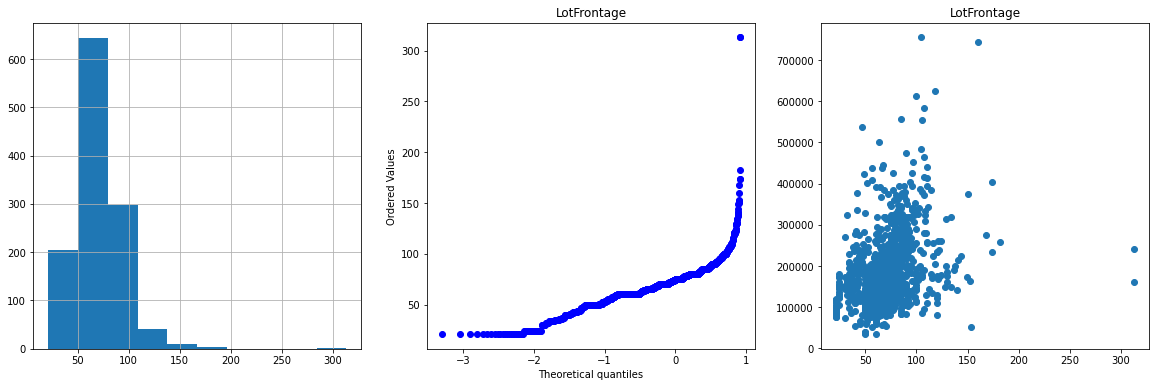

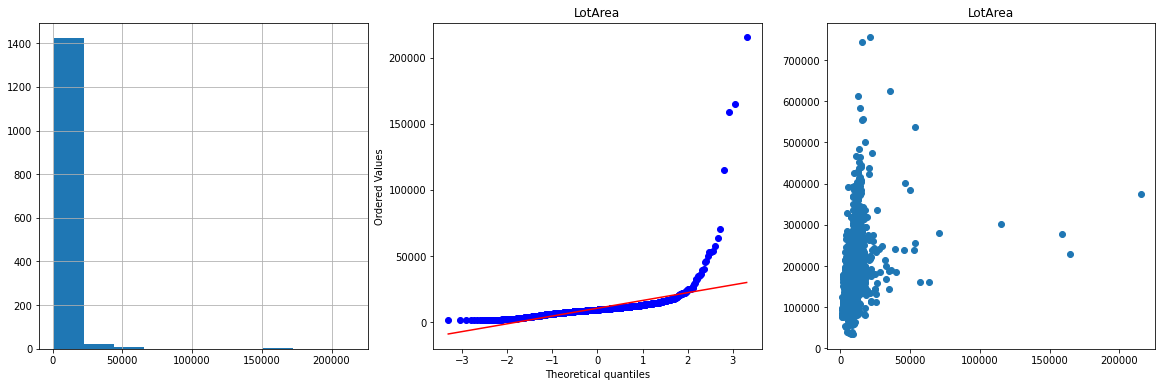

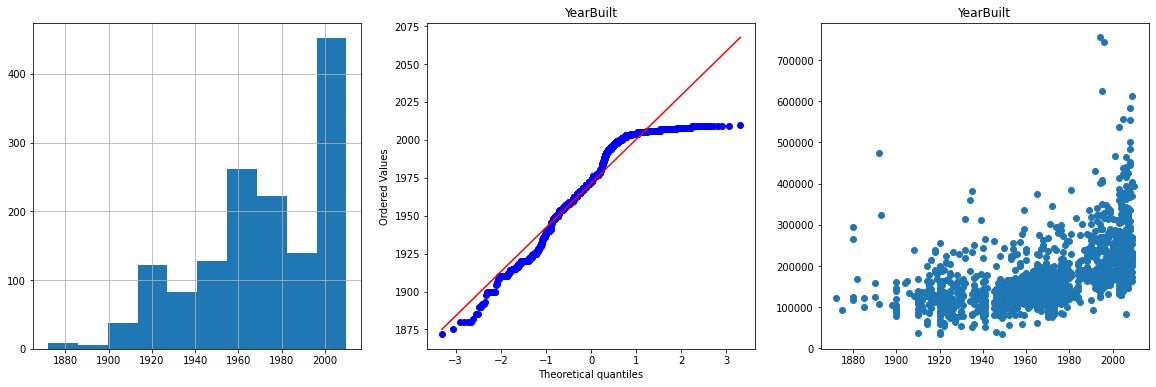

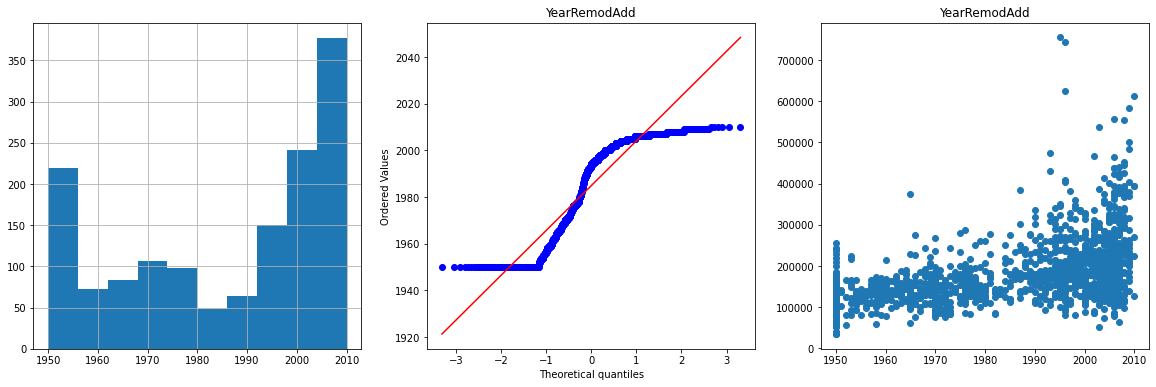

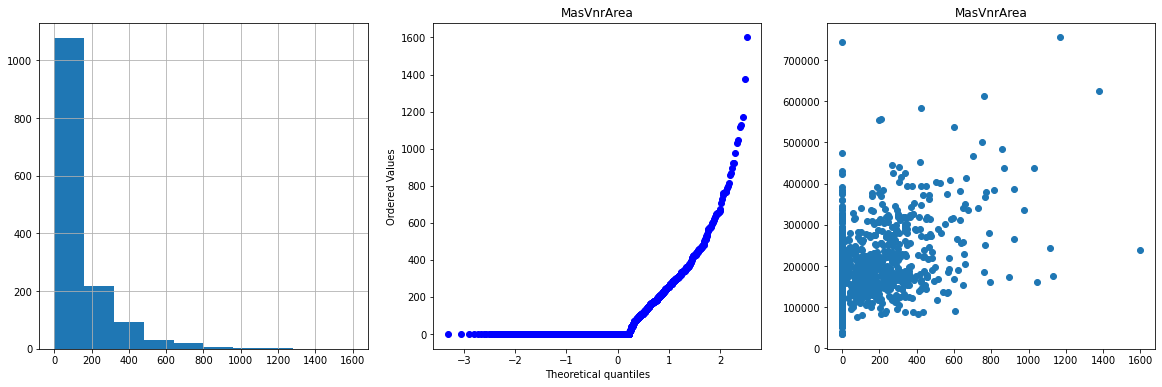

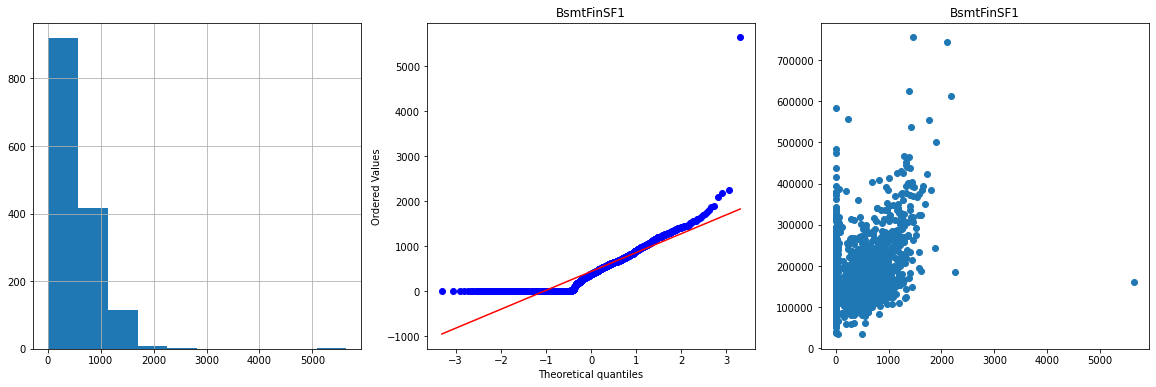

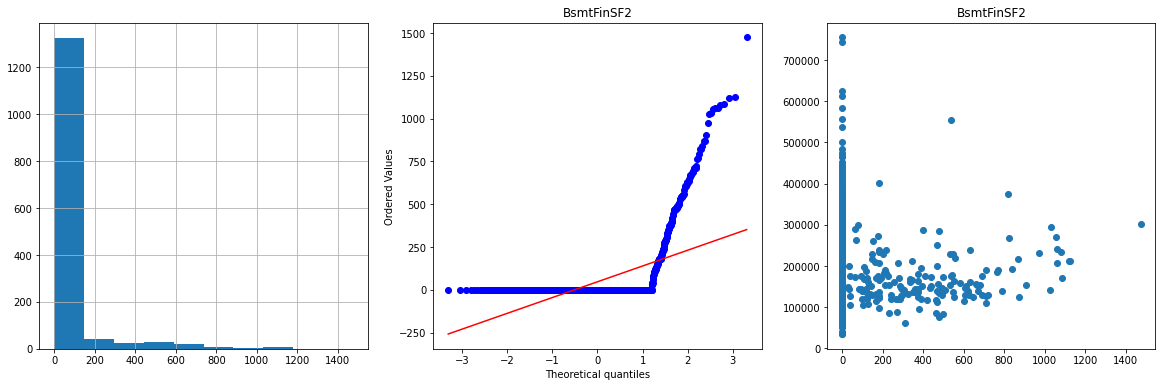

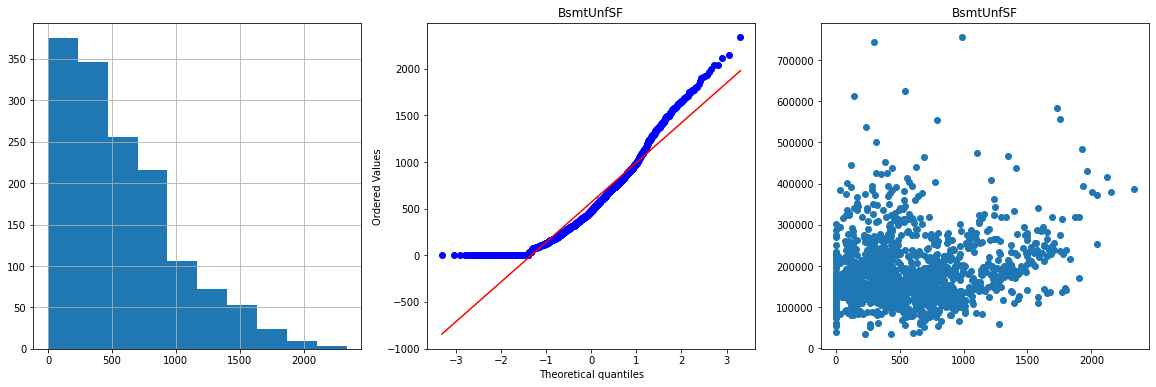

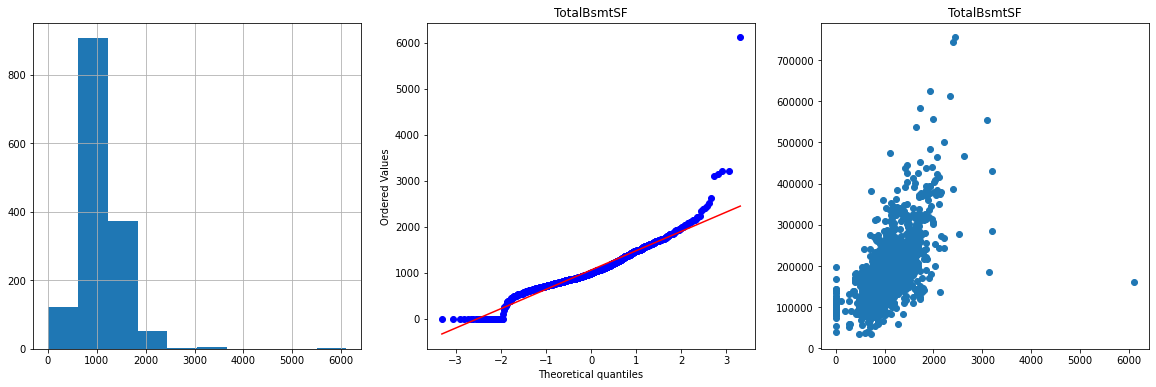

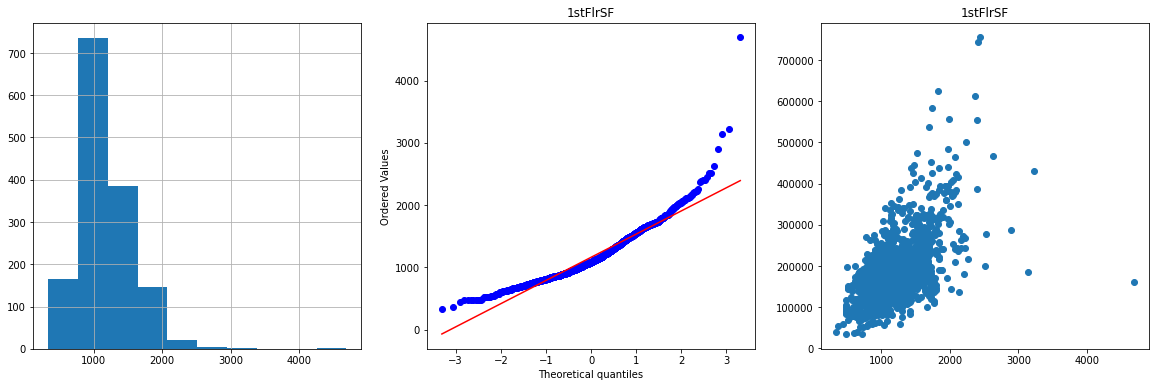

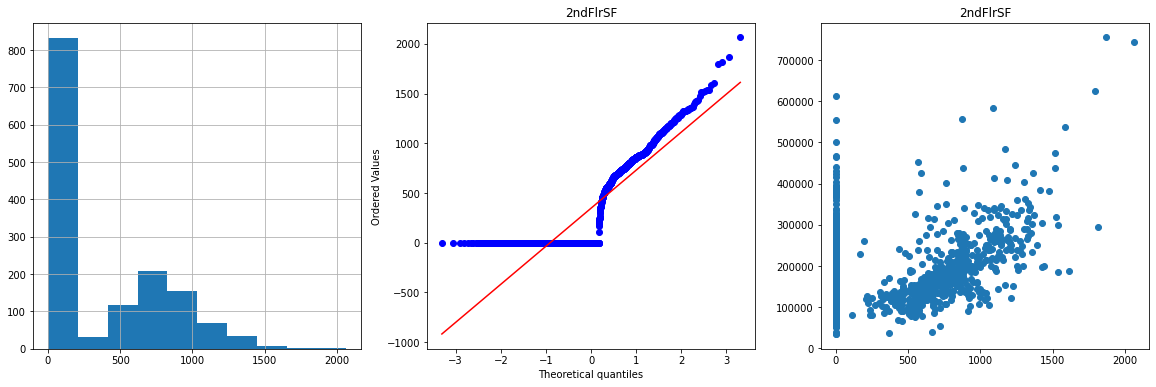

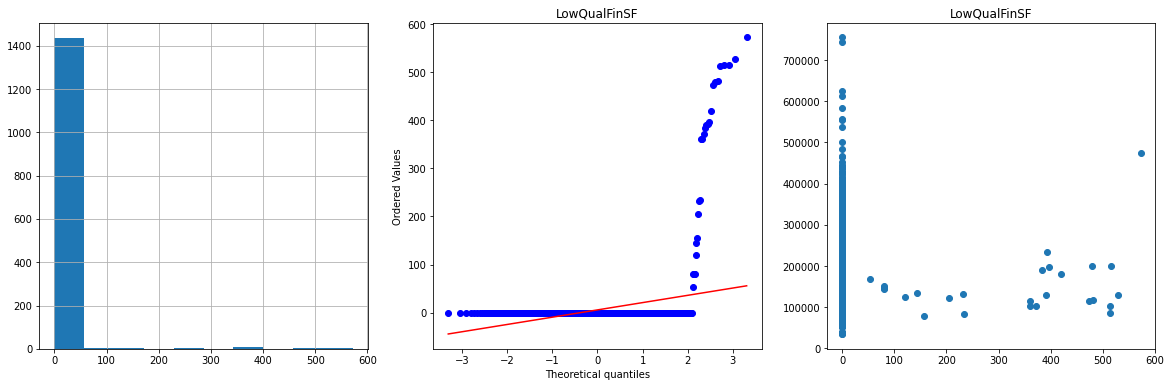

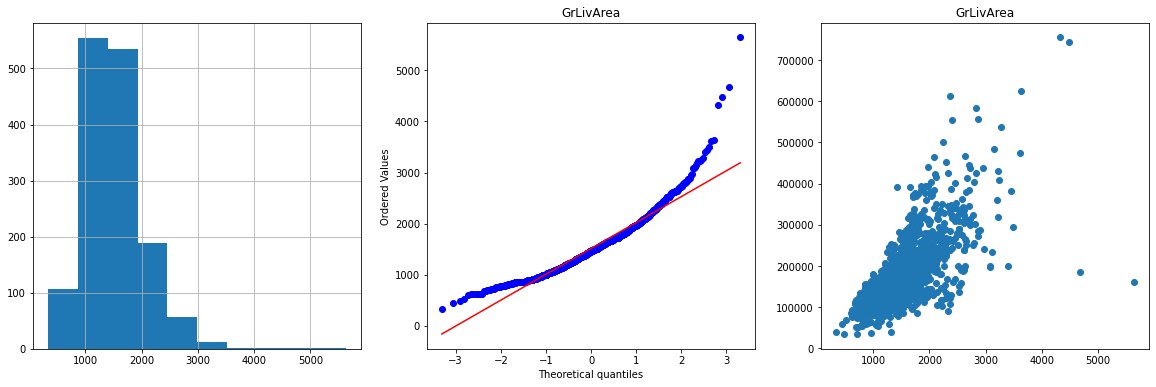

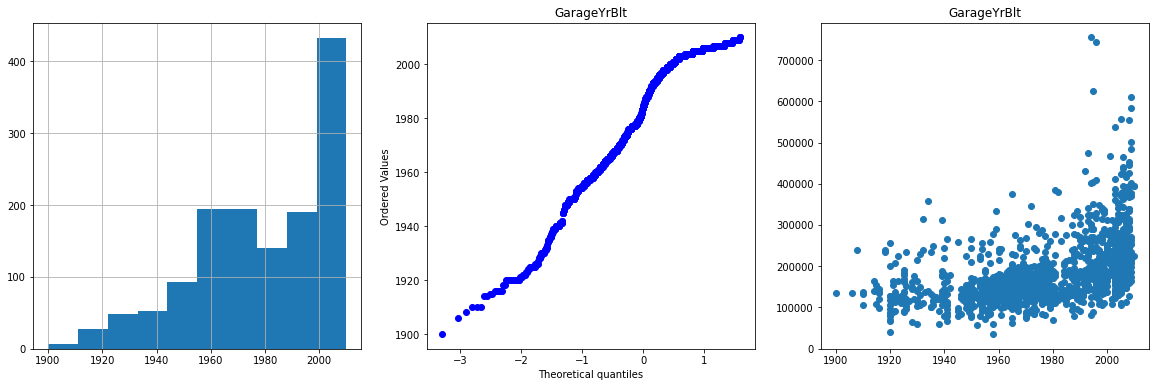

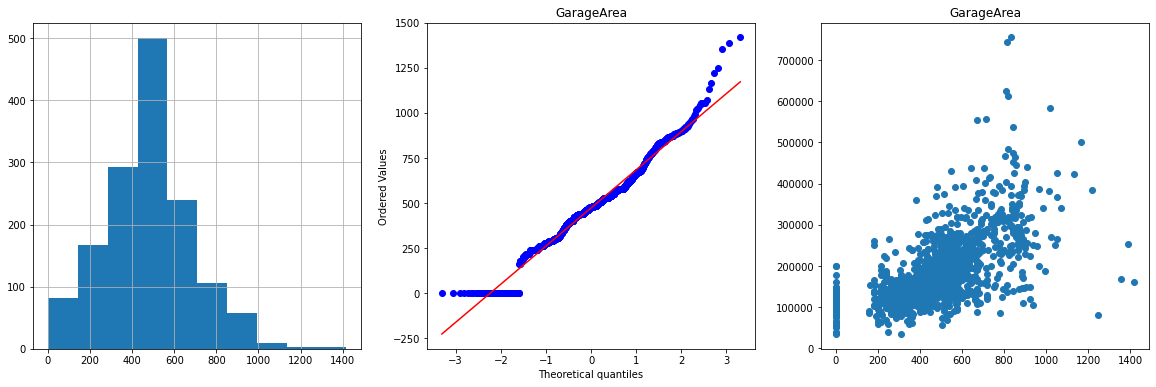

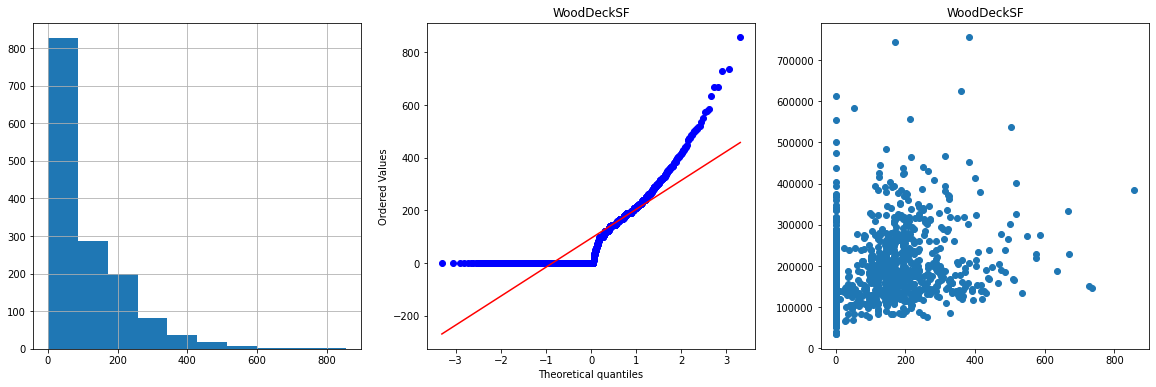

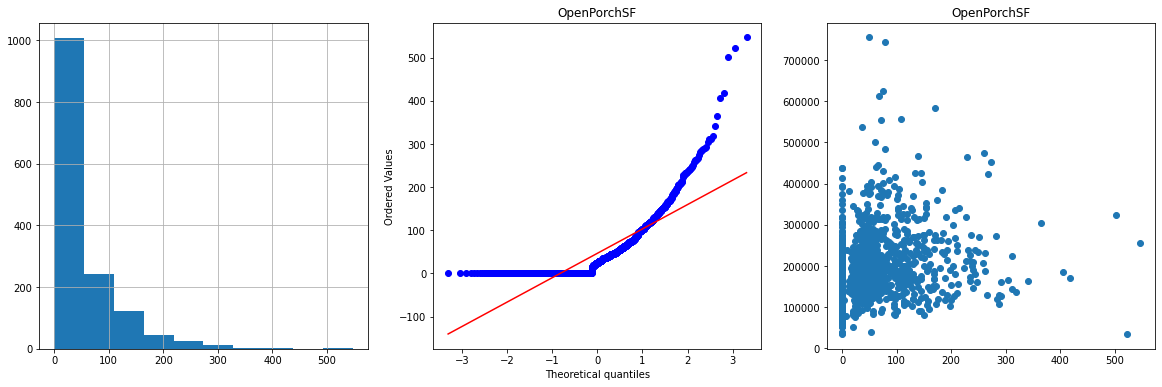

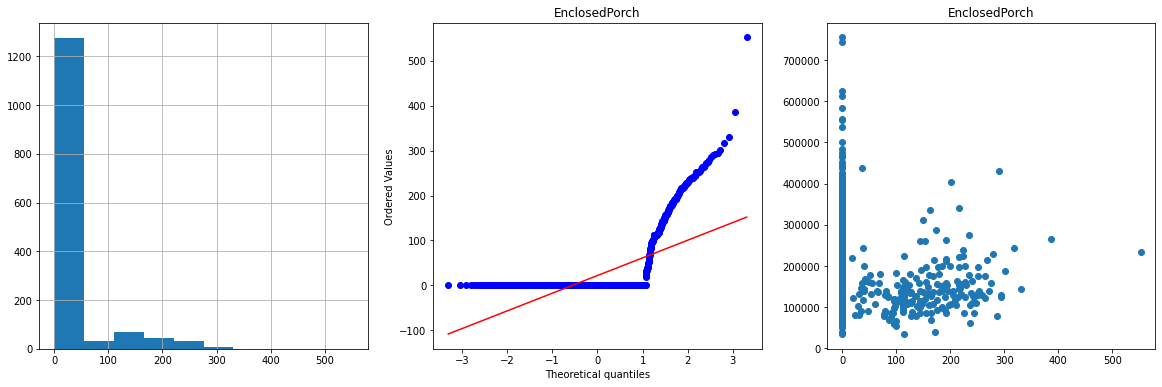

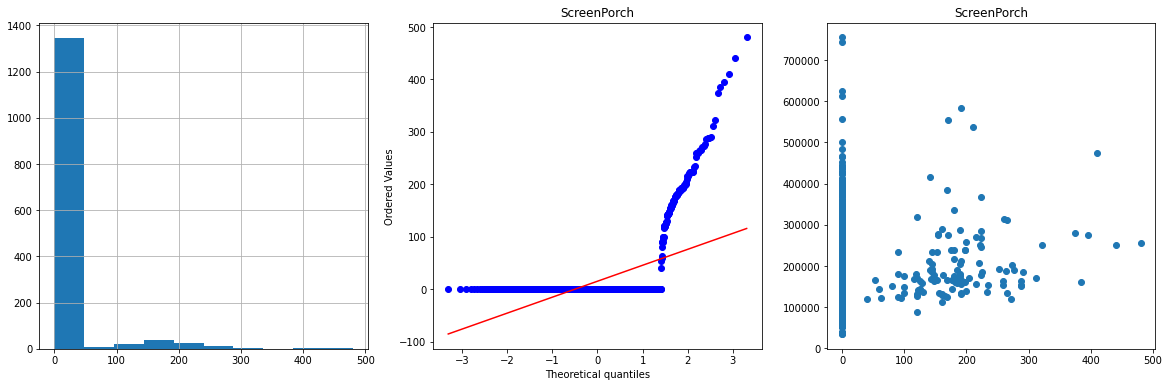

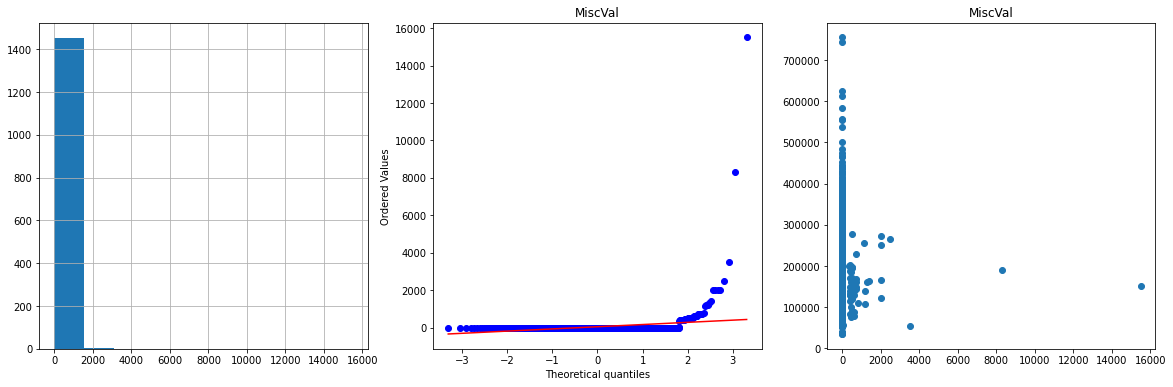

In [19]:
#Univariate analysis using some visuals to determine if we should remove some numerical features
for col in numerical:
    diagnostic_plots(X_train, col, y_train)

Observations for the features

1. Lot Frontage: Skewed to the right due to some big outliers
2. LotArea: Skewed to the right (Big Outliers)
3. YearBuilt: Values capped at a maximum (Close to a linear relationship with the target)
4. YearRemodAdd: Bimodal. Peaks are near the bottom and top of the distribution
5. MasVnrArea: A lot of observations at 0 because there isn't a Masonry. Skewed to the right
6. BsmtFinSF1: Skewed to the right because almost half the values are 0 
7. BsmtFinSF2: Skewed to the right becasue 75 percent of the values are 0 
8. BsmtUnfSF: Skewed to the right (Could be correlated with TotalBsmtSF) 
9. TotalBsmtSF: Almost normally distributed. Some outliers to the right (Small amount of values are 0)
10. 1stFlrSF: Almost normally distributed. Some outliers to the right and left
11. 2ndFlrSF: Linear relationship with the target if you ignore the observations with no 2nd Flr
12. LowQualFinSF: Almost all of the values are 0 
13. GRLivArea: Almost normally distributed. Some outliers to the right (Remove them from the train set)
14. GarageYrBlt: Skewed to the left
15. GarageArea: Almost normally distributed. High variance for big values in relation to the target
16. WoodDeckSF: Half the values are 0  and no linear relationship
17. OpenPorchSF: Half the values are 0  and no linear relationship
18. EnclosedPorch: Half the values are 0  and no linear relationship
19. ScreenPorch: Half the values are 0  and no linear relationship
20. MiscVal: Most of the values are 0 and there is no linear relationship

In [20]:
#Log Transformation
log_variables = ['1stFlrSF', 'LotFrontage', 'GrLivArea']

#Variables that are going to be discretised
discretisation = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

#Outliers that will have its values trimmed
outliers = ['LotArea', 'TotalBsmtSF']

#Variables that will be removed
remove= ['MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF',
         'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal']

#Variables that reqire no maintenance
nothing = ['GarageArea']

In [21]:
#Let's impute the missing values using KNNImputer
imputer = KNNImputer(
    n_neighbors=10,
    weights='distance'
                )

#KNN Imputer does not work on categorical variables 
#So we'll have to create a temporary dataframe to be combined 
#with the main dataframe for later

imputer.fit(X_train[numerical], y_train)

#Store the dataframe indices for later
train_indices = X_train.index
test_indices = X_test.index

#Create a dataframe for the numercial variable
train_num_df = pd.DataFrame(data = imputer.transform(X_train[numerical]),
                            columns = numerical,
                            index = train_indices
                           )
test_num_df = pd.DataFrame(data = imputer.transform(X_test[numerical]),
                           columns = numerical,
                           index = test_indices)

In [22]:
#Log Transformer
from feature_engine import variable_transformers as vt

#Create the log transformer
log_transformer = vt.LogTransformer(variables=log_variables)

#Fit the log transformer to the train dataset
log_transformer.fit(train_num_df)

#Transform both the train and test set
train_num_df = log_transformer.transform(train_num_df)
test_num_df = log_transformer.transform(test_num_df)

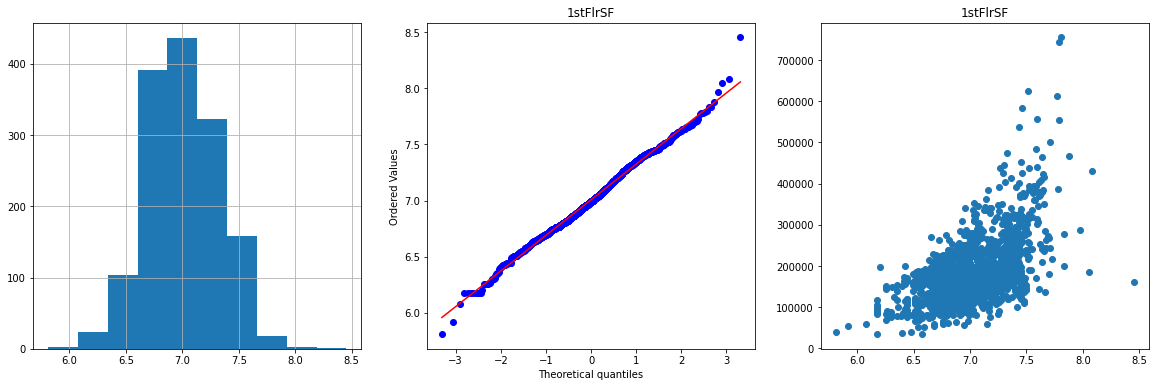

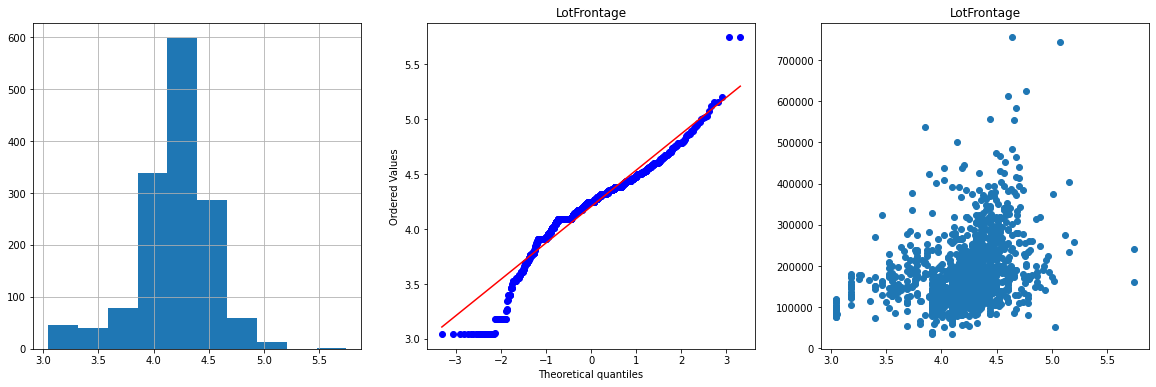

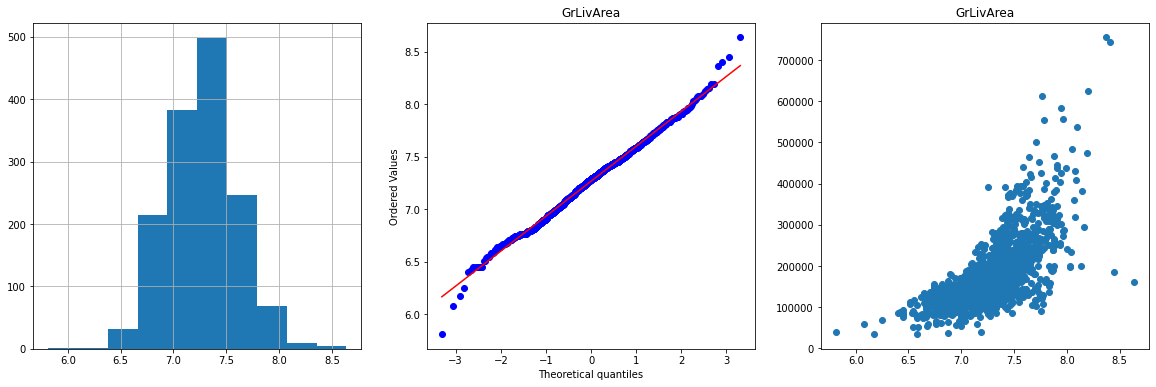

In [23]:
for col in log_variables:
    diagnostic_plots(train_num_df, col, y_train)

In [24]:
#There are still some significant outliers for LotFrontage and GrLivArea
#I'm going to add them the list of outliers
outliers.append('LotFrontage')
outliers.append('GrLivArea')

Observation about the above variables

All of these features are heteroskedastic and can distort the standard error and the significance of the features during modeling

In [25]:
#Discretising the features that have a lot of 0s
from feature_engine.discretisers import EqualFrequencyDiscretiser

#Create the discretiser
disc = EqualFrequencyDiscretiser(q=3, variables = discretisation)

#Fir the discretiser to the train set
disc.fit(train_num_df)

#Transform the train set and the test set
train_num_df = disc.transform(train_num_df)
test_num_df = disc.transform(test_num_df)

In [26]:
#This function will help us in identifying outliers
def find_skewed_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [27]:
#I'm going to cap the outliers with the upper boundary value 
#The upper boundary is 1.5x the Interquantile range

for col in outliers:
    upper_boundary, lower_boundary = find_skewed_boundaries(train_num_df, col, 1.5)
    train_num_df[col] = np.where(train_num_df[col] > upper_boundary, upper_boundary,
                   np.where(train_num_df[col] < lower_boundary, lower_boundary, train_num_df[col]))
    test_num_df[col] = np.where(test_num_df[col] > upper_boundary, upper_boundary,
               np.where(test_num_df[col] < lower_boundary, lower_boundary, test_num_df[col]))

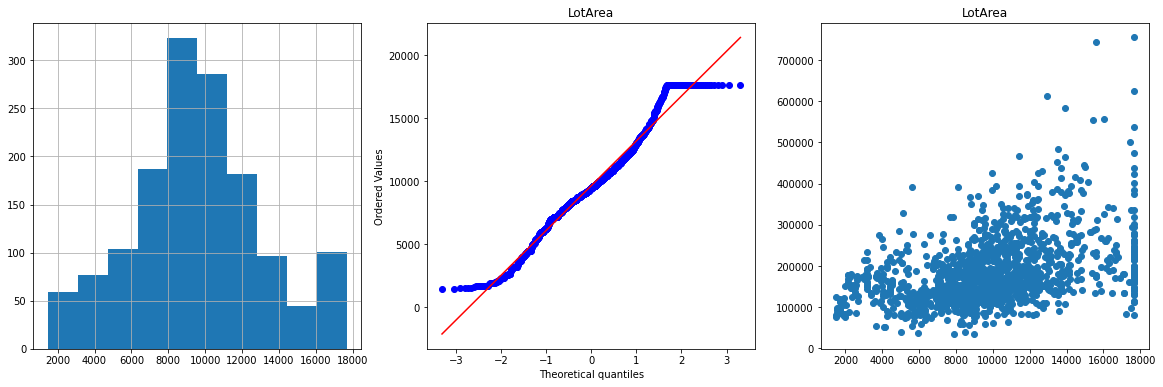

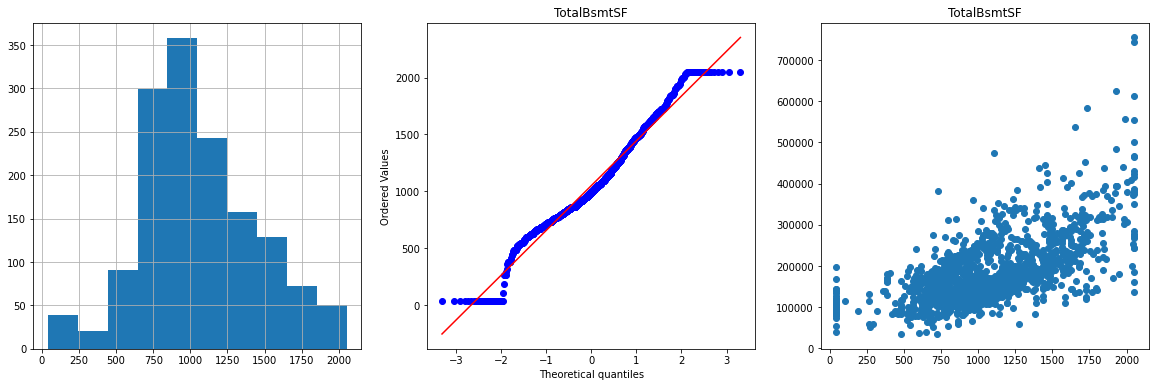

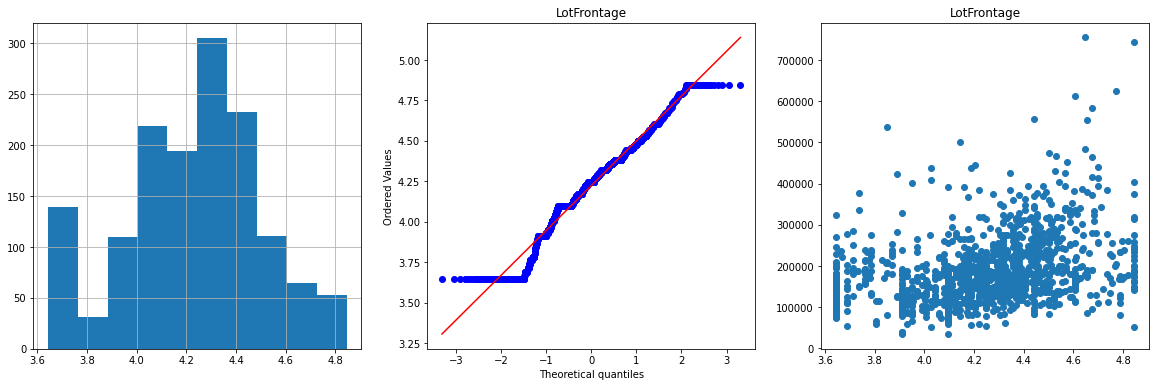

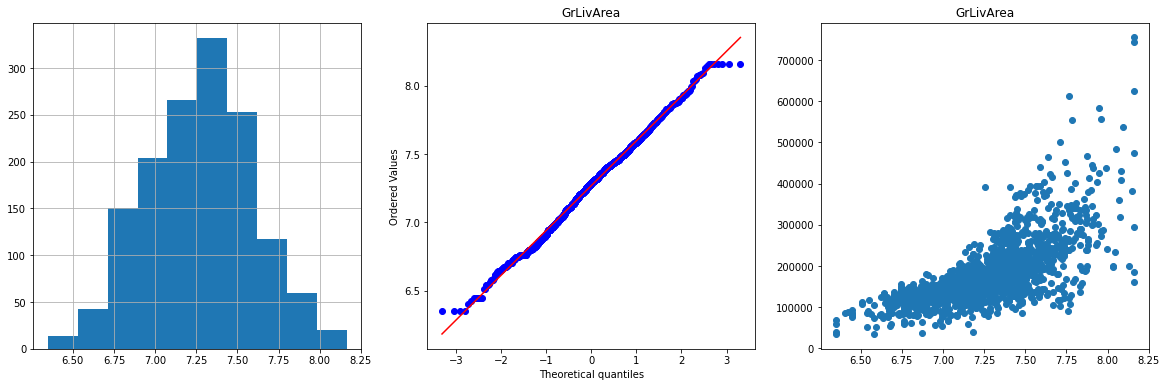

In [28]:
for col in outliers:
    diagnostic_plots(train_num_df, col, y_train)

In [29]:
#Some of these features are heteroskedastic as well
#Removing the bad numerical features 
train_num_df.drop(remove, axis=1, inplace=True)
test_num_df.drop(remove, axis=1, inplace=True)

for col in remove:
    numerical.remove(col)    

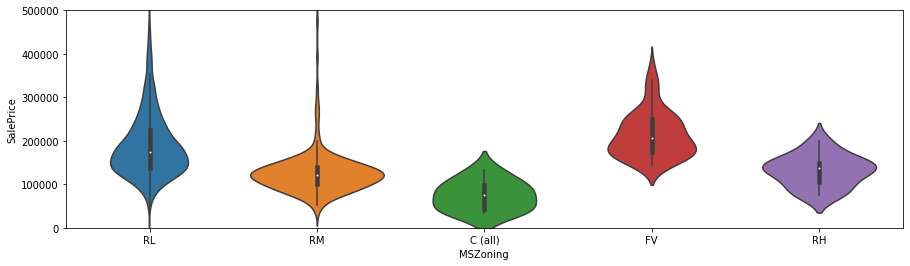

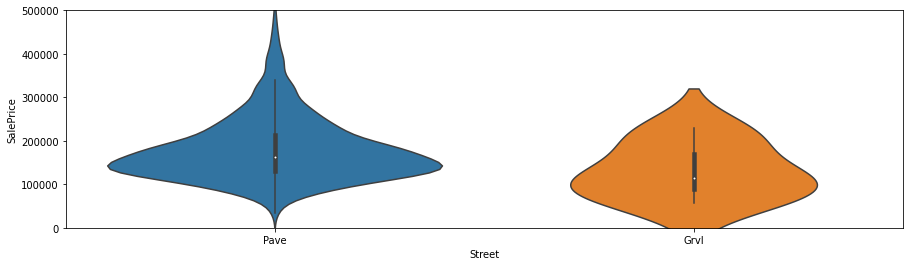

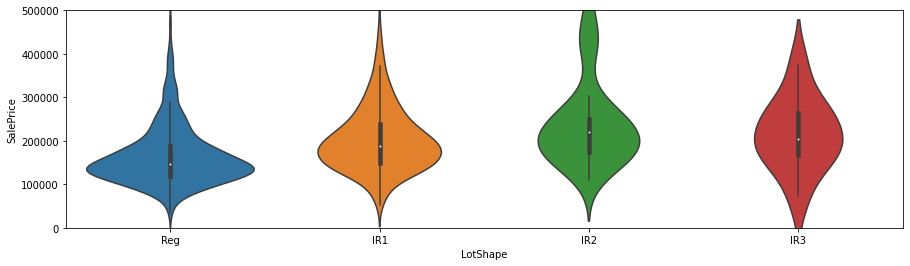

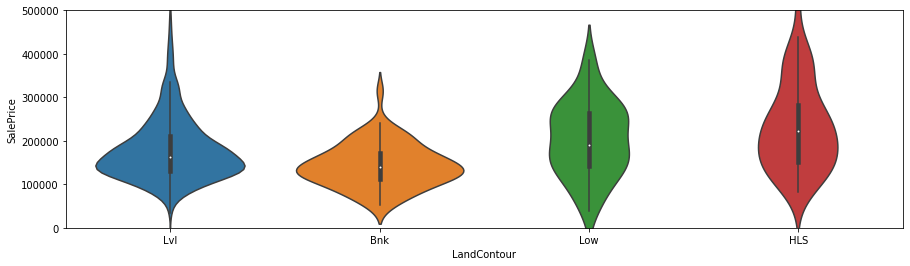

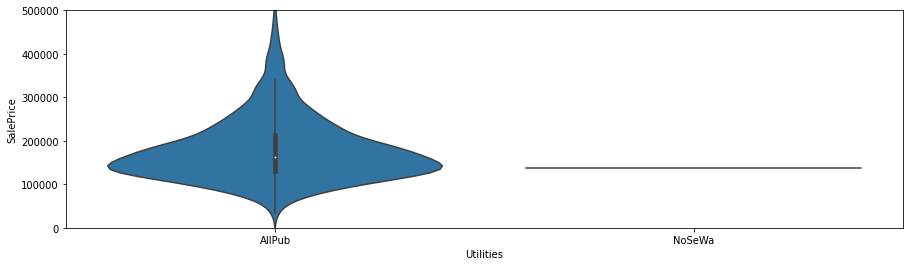

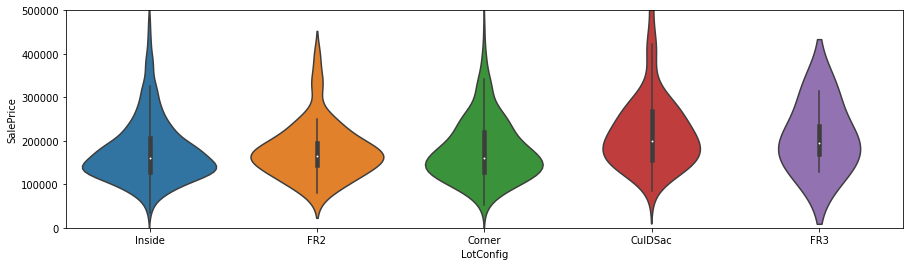

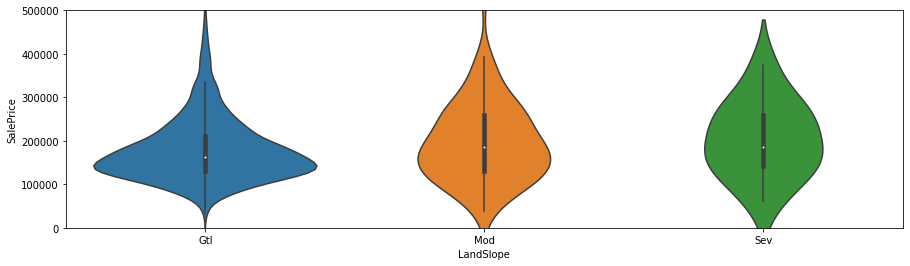

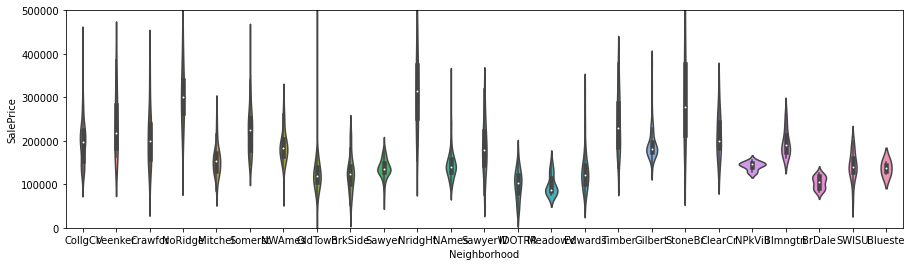

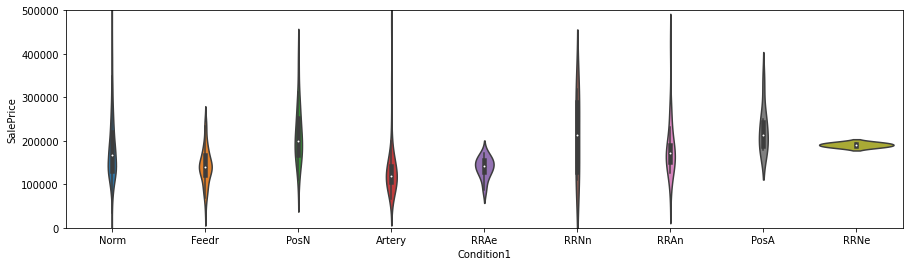

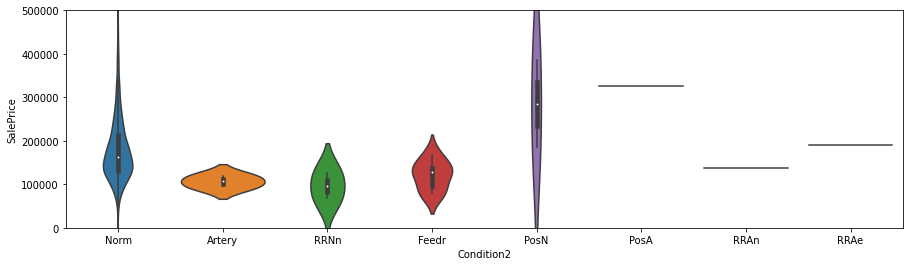

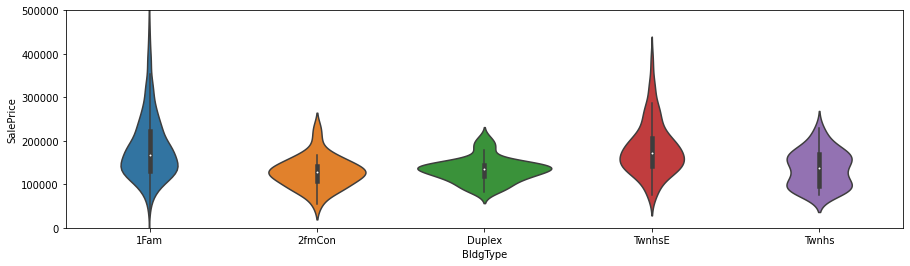

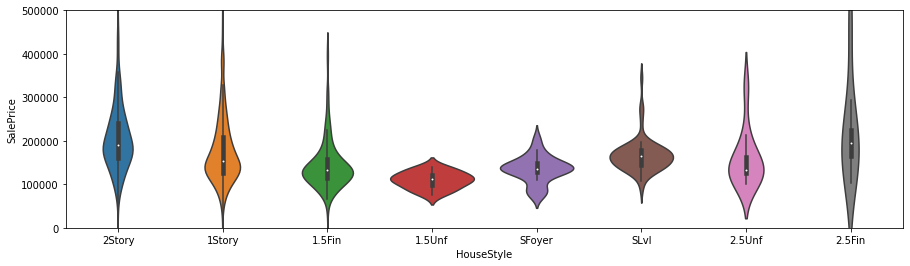

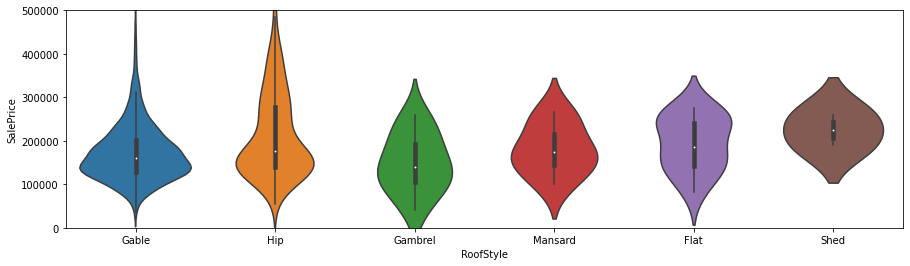

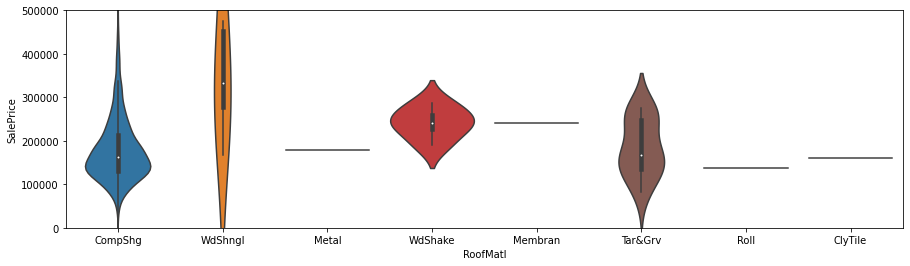

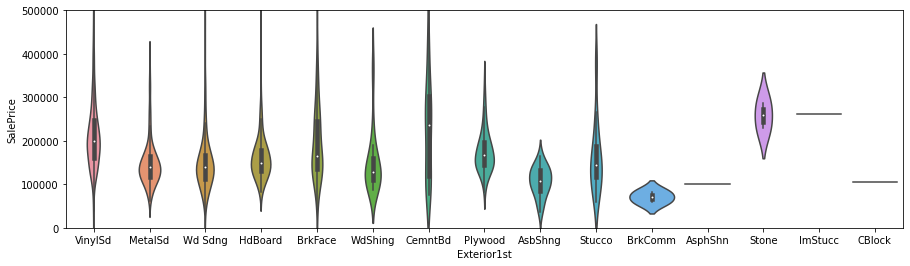

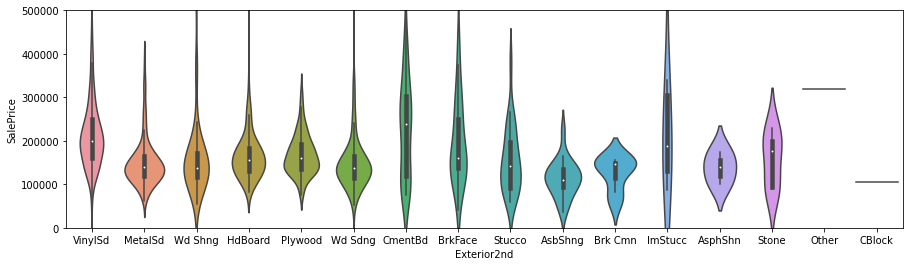

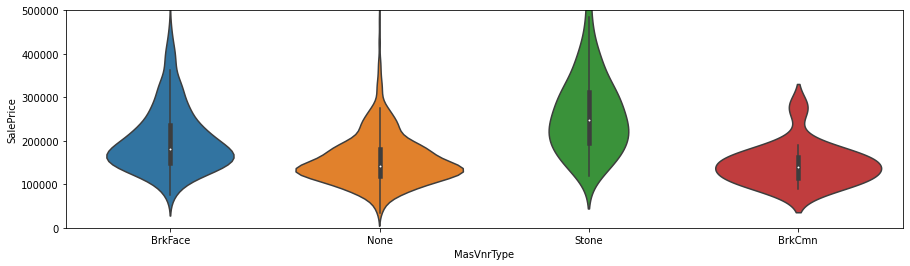

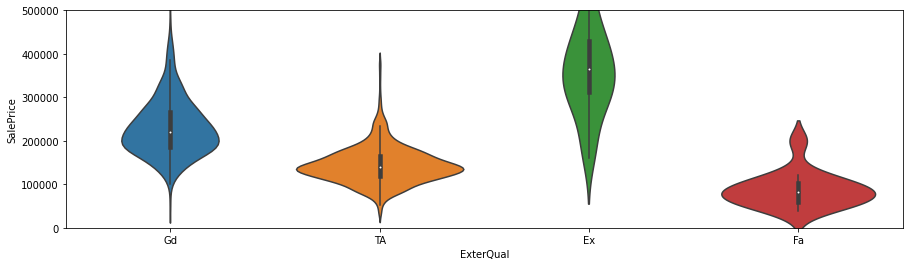

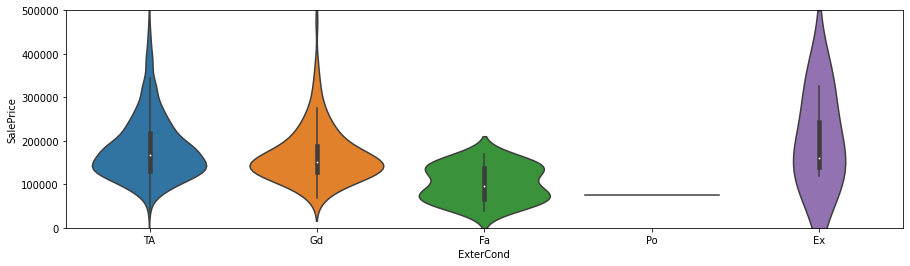

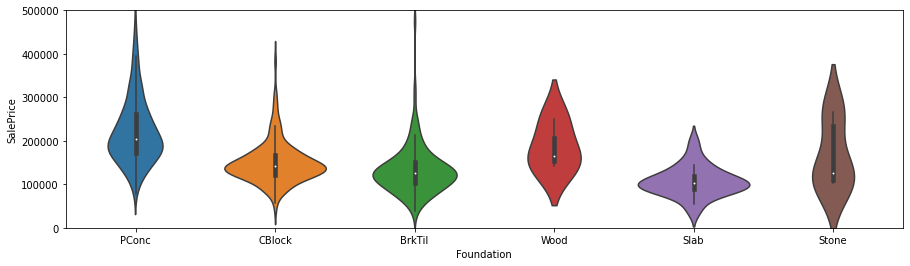

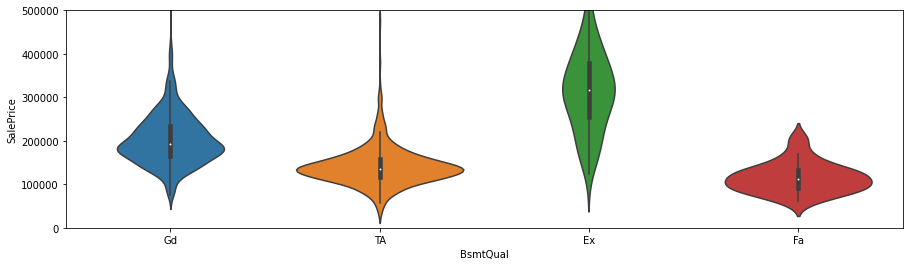

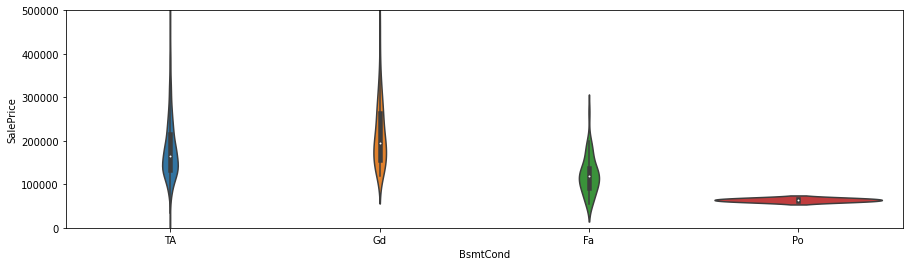

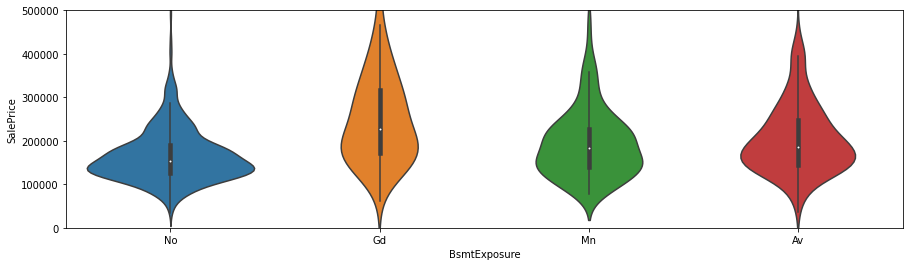

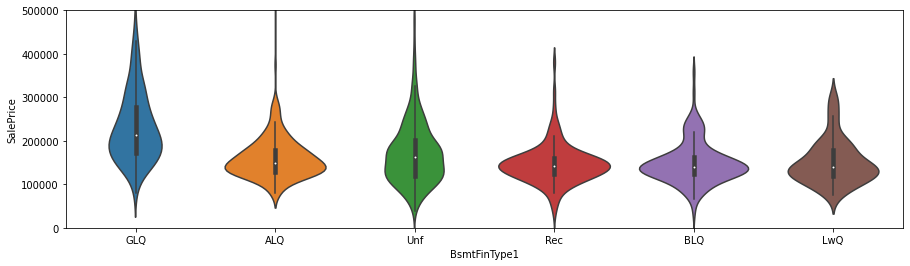

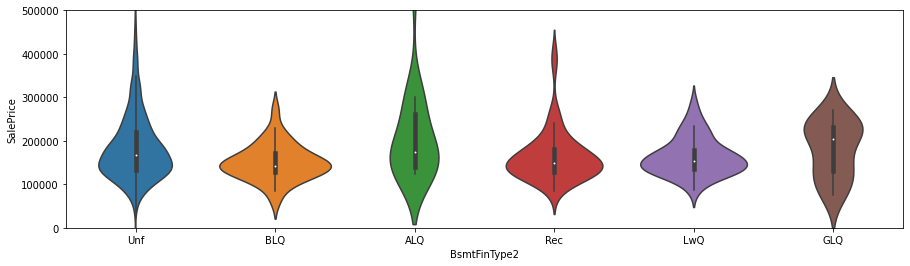

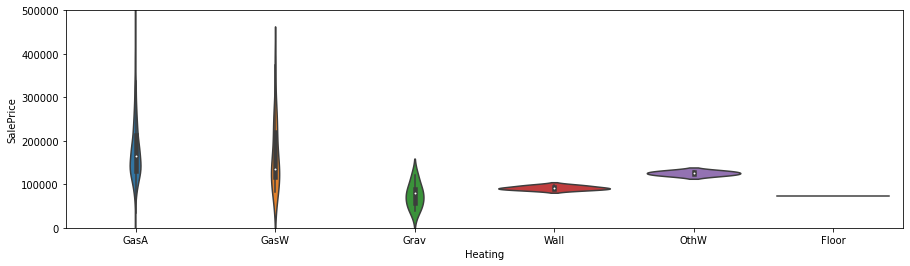

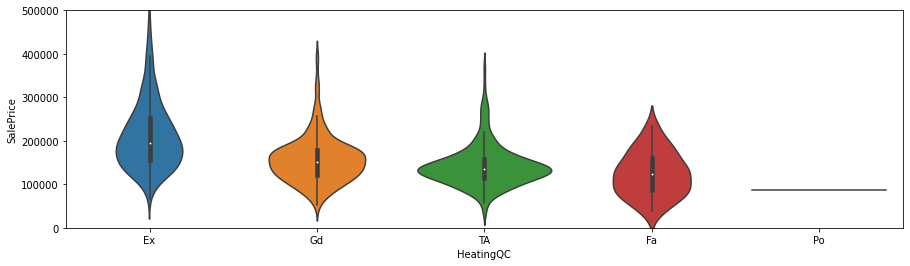

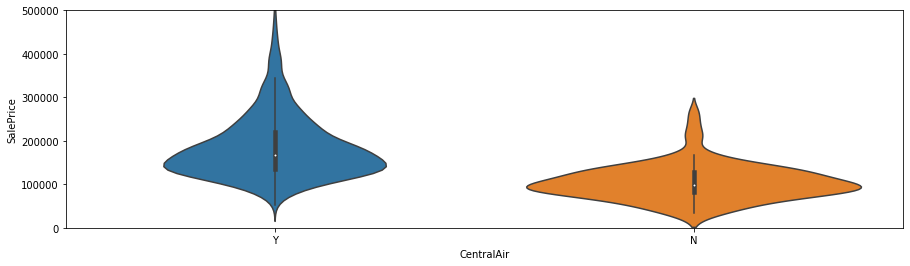

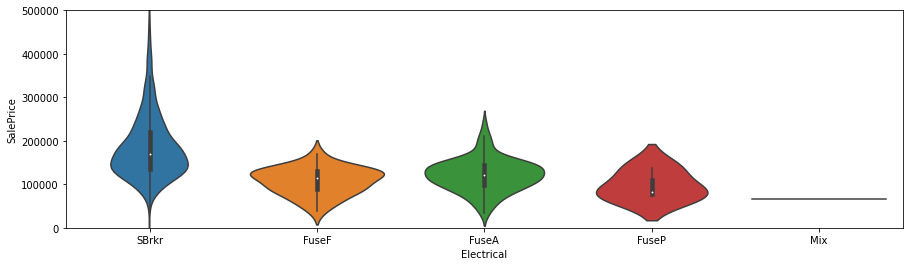

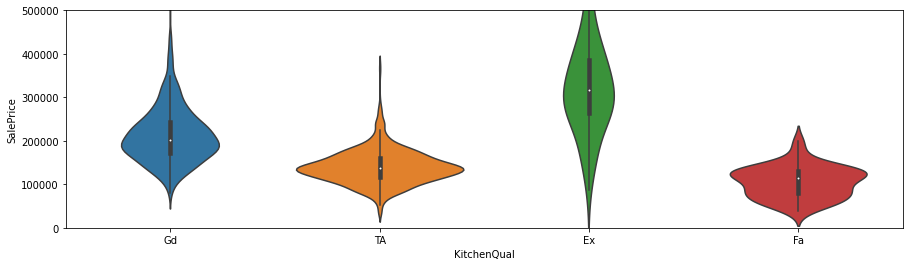

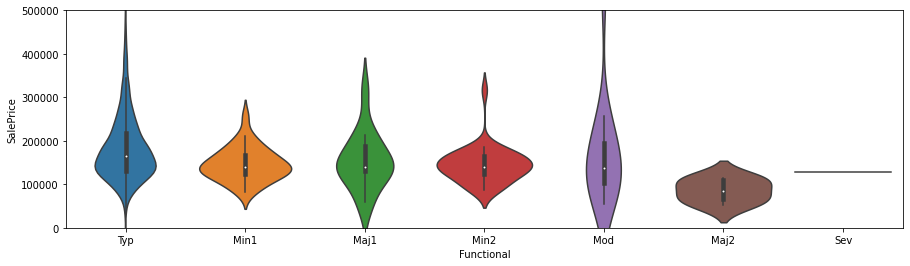

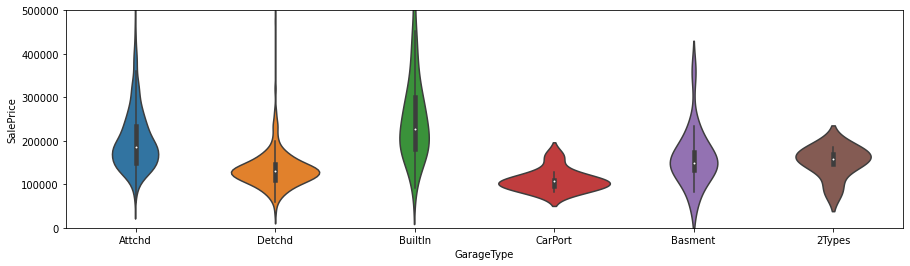

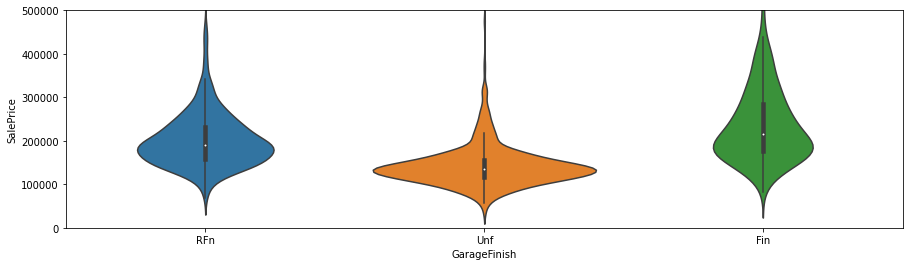

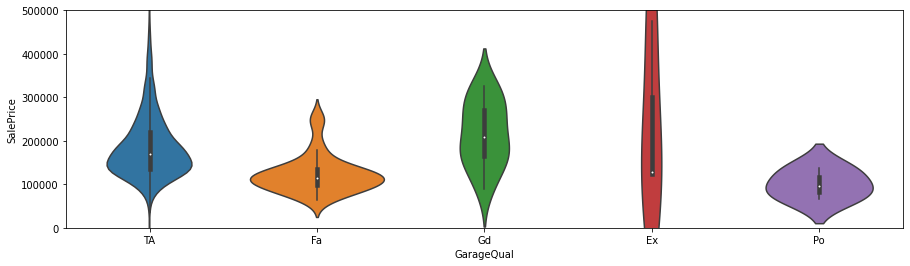

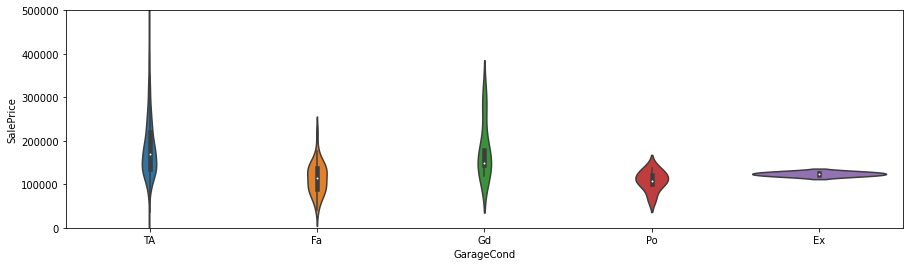

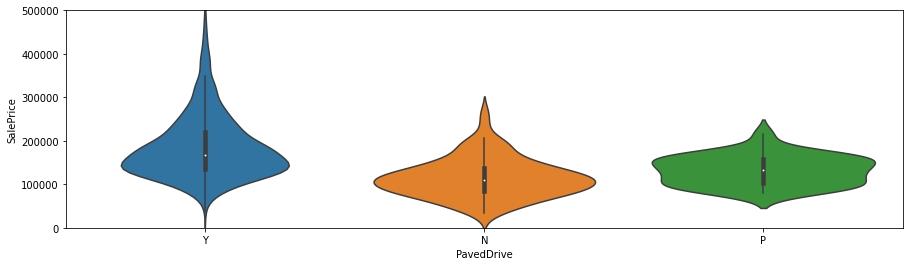

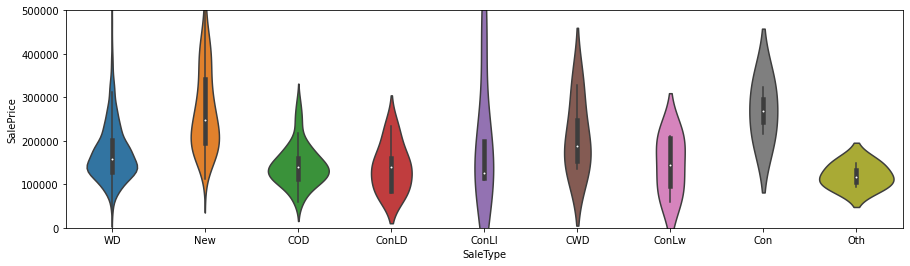

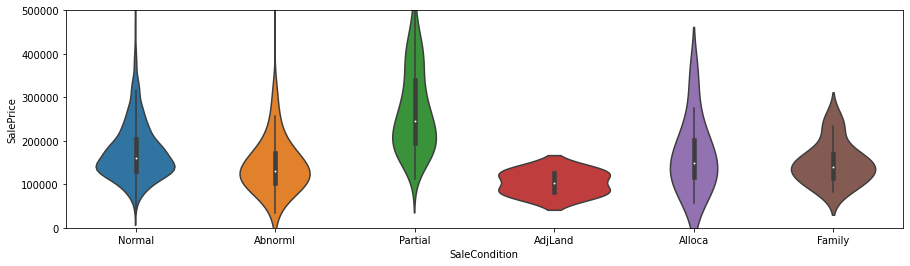

In [30]:
#Conduct bivariate analysis for categorical variables using violinplot
for col in categorical:
    plt.figure(figsize=(15,4))
    sns.violinplot(x=col, y='SalePrice', kind='box', data=train)
    plt.ylim(0,500000) 
    plt.show()

In [31]:
#It seems, from the vionlion plots, that a number of the categorical variables are not very significant
#due to class inbalances, low variance
#Let's drop them

cat_dropped = ['Street', 'Utilities', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior2nd', 'ExterQual', 'Foundation',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
               'Electrical', 'GarageQual', 'GarageCond', 'PavedDrive','SaleCondition']

train_cat_df = X_train[categorical].copy()
test_cat_df = X_test[categorical].copy()

train_cat_df.drop(cat_dropped, axis=1, inplace=True)
test_cat_df.drop(cat_dropped, axis=1, inplace=True)

for col in cat_dropped:
    categorical.remove(col)

In [32]:
#Imputing the missing values for the categorical features with a new category('missing') in order
# to capture the significance of their missingness

missing_categorical = [col for col in categorical if (train_cat_df[col].isnull().sum()> 0 
                                                    or test_cat_df[col].isnull().sum() >0 )]


cat_imputer = mdi.CategoricalVariableImputer(variables=missing_categorical)

train_cat_df = cat_imputer.fit_transform(train_cat_df)
test_cat_df = cat_imputer.fit_transform(test_cat_df)

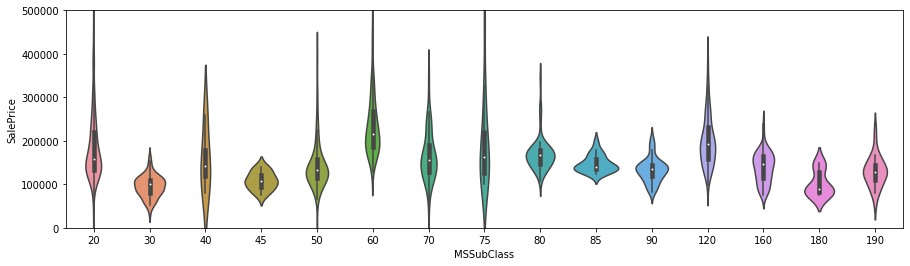

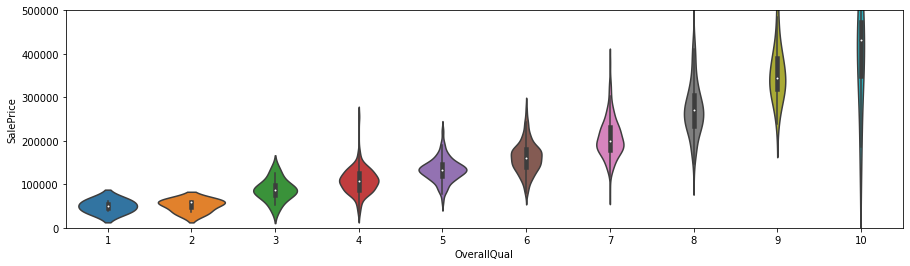

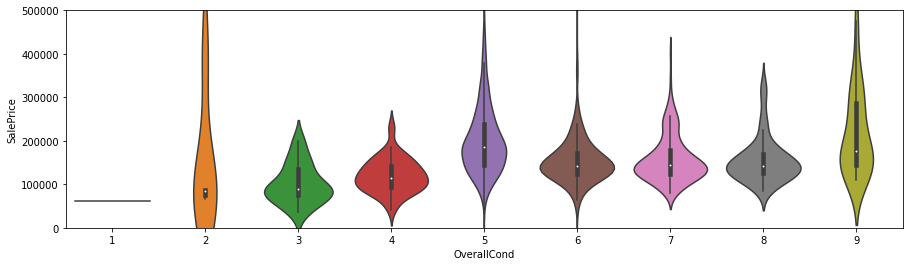

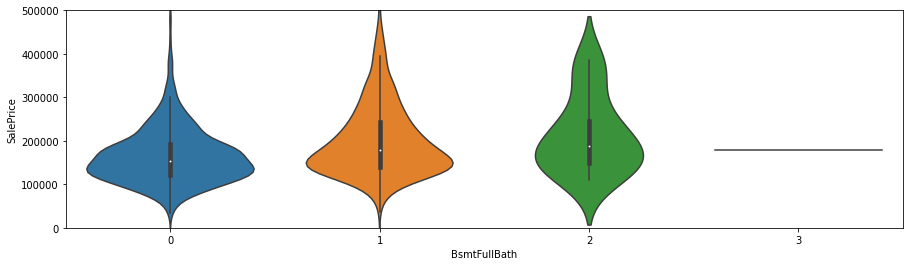

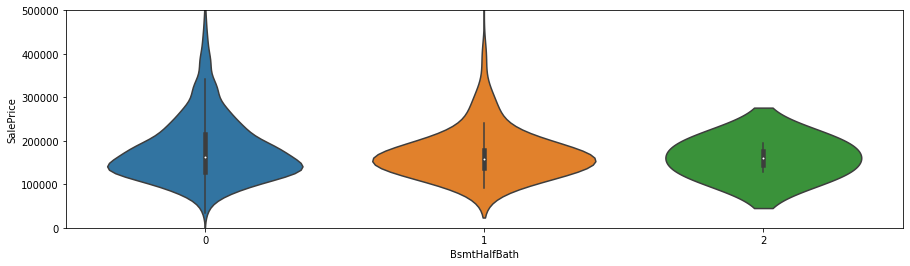

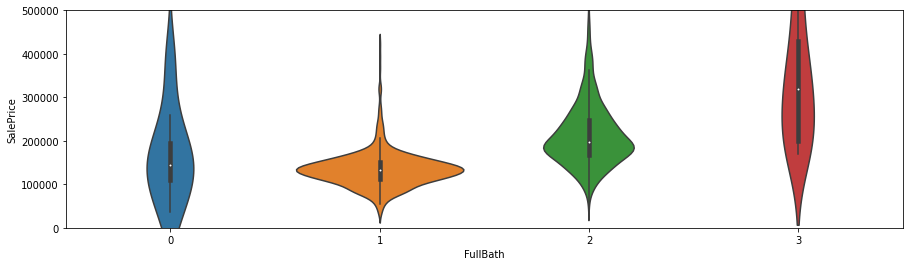

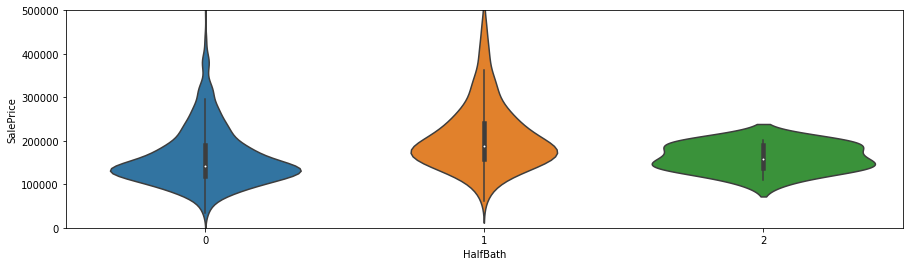

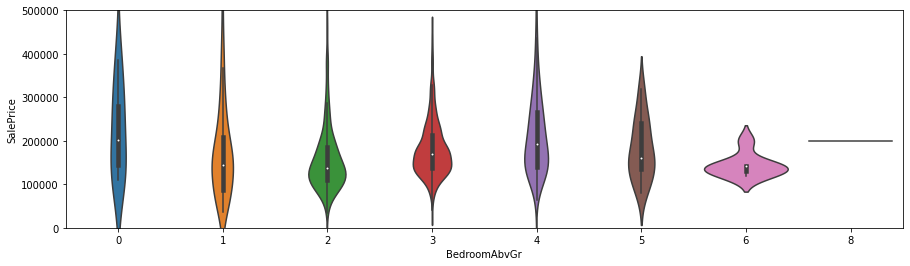

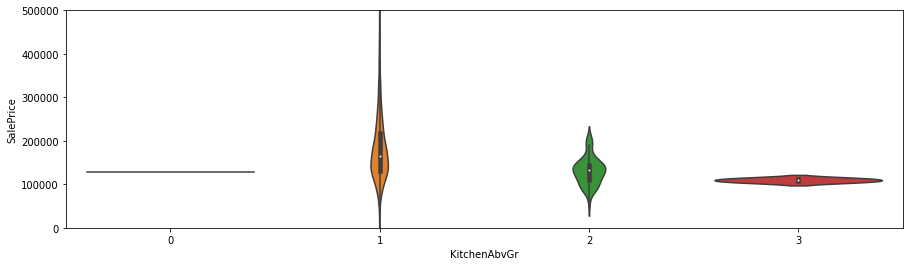

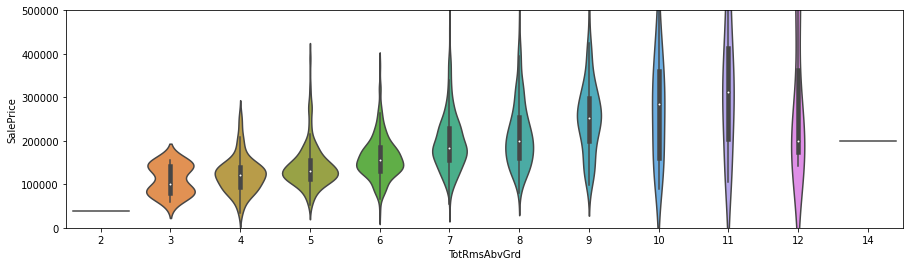

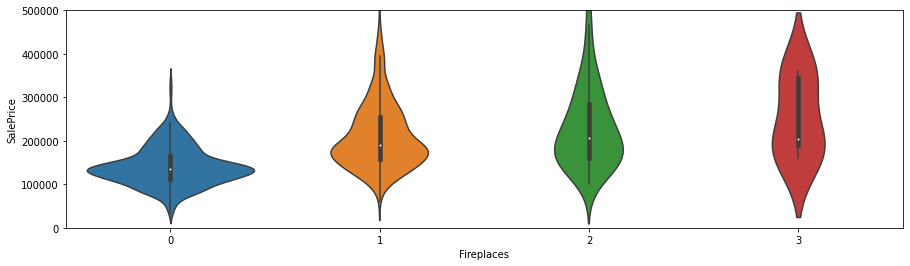

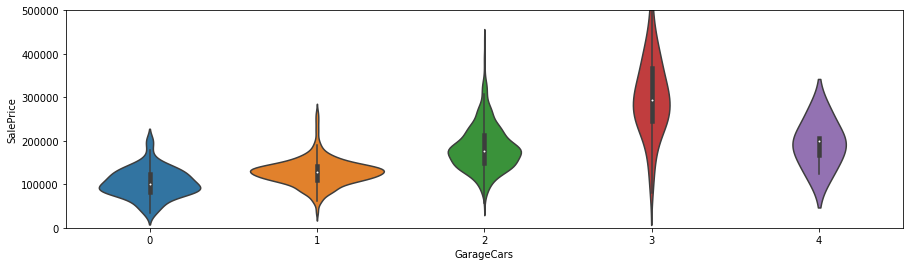

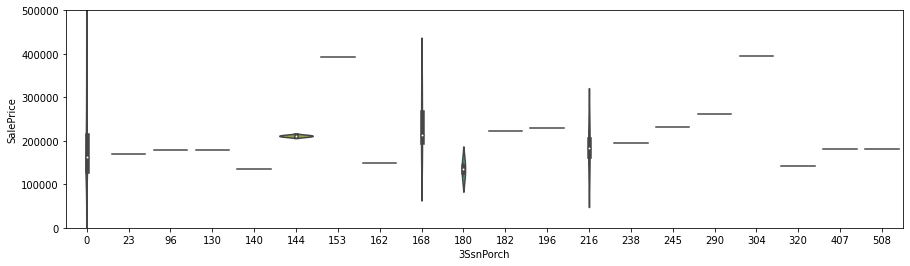

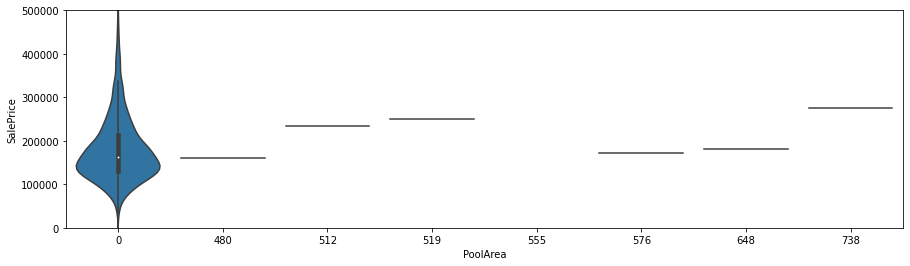

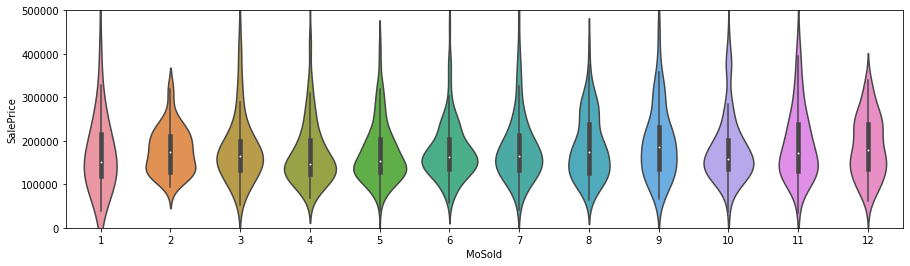

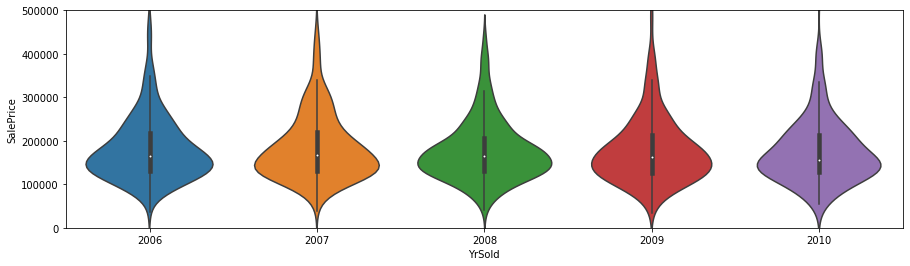

In [33]:
#Let's visualize the numerical variables that are discrete using violinplots
for col in discrete:
    plt.figure(figsize=(15,4))
    sns.violinplot(x=col, y='SalePrice', kind='box', data=train)
    plt.ylim(0,500000) 
    plt.show()

In [34]:
#Dropping the insignificant discrete variables

discrete_dropped = ['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                    'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MoSold','YrSold']

train_dis_df = X_train[discrete].copy()
test_dis_df = X_test[discrete].copy()

train_dis_df.drop(discrete_dropped, axis=1, inplace=True)
test_dis_df.drop(discrete_dropped, axis=1, inplace=True)

for col in discrete_dropped:
    discrete.remove(col)

In [35]:
#Impute missing values for discrete variables with the median values

#Identify variables that have a missing value
discrete_missing = [col for col in discrete if 
                     (train_dis_df[col].isnull().sum()>0 or test_dis_df[col].isnull().sum()>0)]
 
#Create the missing imputer
missing_imputer = mdi.MeanMedianImputer(imputation_method='median', variables=discrete_missing)

#Fit the missing imputer with the train dataset
missing_imputer.fit(train_dis_df)

#Transform both the train and test dataframes
train_dis_df = missing_imputer.transform(train_dis_df)
test_dis_df = missing_imputer.transform(test_dis_df)

In [36]:
#Combine the dataframes with numerical, categorical and discrete variables

x_train = pd.concat([train_num_df, train_cat_df, train_dis_df], axis=1)
x_test = pd.concat([test_num_df, test_cat_df, test_dis_df], axis=1)

In [37]:
#Using a One Hot encoder for all of the categorical variables

from feature_engine.categorical_encoders import OneHotCategoricalEncoder as ohe

oh_encoder = ohe(top_categories=3, variables=categorical)

oh_encoder.fit(x_train)

x_train = oh_encoder.transform(x_train)
x_test = oh_encoder.transform(x_test)

In [39]:
#Identify groups of correlated features

corrmat = x_train.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat

,feature1,feature2,corr
0,LotShape_Reg,LotShape_IR1,0.925959
1,LotShape_IR1,LotShape_Reg,0.925959
2,ExterCond_Gd,ExterCond_TA,0.894567
3,ExterCond_TA,ExterCond_Gd,0.894567
4,GarageCars,GarageArea,0.882475
5,GarageArea,GarageCars,0.882475
6,YearBuilt,GarageYrBlt,0.833171
7,GarageYrBlt,YearBuilt,0.833171
8,GrLivArea,TotRmsAbvGrd,0.826135
9,TotRmsAbvGrd,GrLivArea,0.826135


In [40]:
#Find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:
        
        #find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1== feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]
        
        #append the block of features to the list
        correlated_groups.append(correlated_block)

print(f'Found {len(correlated_groups)} Correlated Groups')
print(f'Out of {X_train.shape[1]} features')

Found 7 Correlated Groups
Out of 74 features


In [41]:
for group in correlated_groups:
    print(group)

       feature1      feature2      corr
0  LotShape_Reg  LotShape_IR1  0.925959
       feature1      feature2      corr
2  ExterCond_Gd  ExterCond_TA  0.894567
     feature1    feature2      corr
4  GarageCars  GarageArea  0.882475
    feature1     feature2      corr
6  YearBuilt  GarageYrBlt  0.833171
    feature1      feature2      corr
8  GrLivArea  TotRmsAbvGrd  0.826135
          feature1        feature2      corr
10  KitchenQual_TA  KitchenQual_Gd  0.824457
       feature1     feature2      corr
12  MSZoning_RL  MSZoning_RM  0.808585


In [42]:
#Import the different Machine Learning algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [43]:
#Rank the features in each correlated group and keep the feature that is the most important
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


for group in correlated_groups:
    correlated_features = list(group.feature1.unique()) + list(group.feature2.unique())
    rf = RandomForestRegressor()
    df = pd.DataFrame(columns=['Feature', 'Score'])
    
    for feature in correlated_features:
        rf = RandomForestRegressor()
        rf.fit(x_train[feature].to_frame(), y_train)
        y_predict = rf.predict(x_train[feature].to_frame())
        score = mean_squared_log_error(y_train, y_predict)
        new_row = {'Feature': feature,
                   'Score': score}
        df = df.append(new_row, ignore_index=True)
        
    df.sort_values(by=['Score'], inplace=True)
    print(df)
    print()

        Feature     Score
0  LotShape_Reg  0.151800
1  LotShape_IR1  0.155596

        Feature     Score
1  ExterCond_TA  0.163274
0  ExterCond_Gd  0.165491

      Feature     Score
1  GarageArea  0.052323
0  GarageCars  0.083009

       Feature     Score
0    YearBuilt  0.105578
1  GarageYrBlt  0.117435

        Feature     Score
0     GrLivArea  0.033535
1  TotRmsAbvGrd  0.114724

          Feature     Score
0  KitchenQual_TA  0.116527
1  KitchenQual_Gd  0.138938

       Feature     Score
1  MSZoning_RM  0.145288
0  MSZoning_RL  0.150771



In [44]:
#Removing a feature in each group that outputs the lowest score

corr_removed = ['LotShape_IR1', 'ExterCond_Gd', 'GarageCars', 
                'TotRmsAbvGrd', 'KitchenQual_Gd',  'MSZoning_RL', 'GarageYrBlt']


x_train.drop(corr_removed, axis=1, inplace=True)
x_test.drop(corr_removed, axis=1, inplace=True)

print(x_train.shape, x_test.shape)

(1460, 54) (1459, 54)


### XGBoost Model

In [45]:
#Optimize the objective function with hyperopt for xgboost


#Definte the search space
space = {
            'base_score' : [.5, .15, .25, .5, .75, .85, .95, .975, .9825, .999],
            'booster' : ['gbtree', 'dart'],
            'importance_type' : ['weight', 'gain', 'cover', 'total_gain', 'total_cover'],
            'learning_rate' : [None, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
            'num_parallel_tree' : [None, 1, 2, 3, 4, 5],
    
         }

#Objective function
cv = KFold(n_splits=8, random_state=24, shuffle=True)

def acc_model(params):
    
    depth = int(params['max_depth'])
    est= int(params['n_estimators'])
   
    regressor = xgb.XGBRegressor(random_state=24,
                                 base_score= params['base_score'],
                                 booster= params['booster'], 
                                 colsample_bylevel= params['colsample_bylevel'], 
                                 colsample_bynode= params['colsample_bynode'],
                                 colsample_bytree= params['colsample_bytree'], 
                                 gamma= params['gamma'], 
                                 importance_type= params['importance_type'],
                                 learning_rate= params['learning_rate'],
                                 max_depth= depth, 
                                 min_child_weight= params['min_child_weight'],
                                 n_estimators=est, 
                                 num_parallel_tree= params['num_parallel_tree'], 
                                 reg_lambda= params['reg_lambda'])
   
    
    return -cross_val_score(regressor, x_train, y_train, scoring='neg_mean_squared_log_error').mean()

#Define the search space
param_space = { 
                'base_score' : hp.choice('base_score', space.get('base_score')),
                'booster': hp.choice('booster', space.get('booster')),
                'colsample_bylevel': hp.uniform('colsample_bylevel', 0, 1),
                'colsample_bynode': hp.uniform('colsample_bynode', 0, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
                'gamma': hp.uniform('gamma',1,15),
                'importance_type': hp.choice('importance_type', space.get('importance_type')),
                'learning_rate': hp.choice('learning_rate', space.get('learning_rate')),
                'max_depth': hp.quniform('max_depth',1,10,1),
                'min_child_weight': hp.uniform('min_child_weight', 1, 100),
                'n_estimators': hp.quniform('n_estimators', 25,1000,1),
                'num_parallel_tree': hp.choice('num_parallel_tree', space.get('num_parallel_tree')),
                'reg_lambda': hp.uniform('reg_lambda',1,15)
            }

best = 1000

def f(params):
    global best
    acc = acc_model(params)
    if acc < best:
        best = acc
        print ('new best:', best, params) 
        
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)
print ('best:')
print (best_params)

new best:                                             
0.024078529832391553                                  
{'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 0.6971037044171295, 'colsample_bynode': 0.4594205336279594, 'colsample_bytree': 0.8445336507250556, 'gamma': 1.9926747392072197, 'importance_type': 'total_cover', 'learning_rate': 0.4, 'max_depth': 10.0, 'min_child_weight': 35.44569982481357, 'n_estimators': 94.0, 'num_parallel_tree': None, 'reg_lambda': 7.282793737034859}
new best:                                                                         
0.02143930615086457                                                               
{'base_score': 0.975, 'booster': 'dart', 'colsample_bylevel': 0.7390884239861051, 'colsample_bynode': 0.7845806110124929, 'colsample_bytree': 0.22282064895795928, 'gamma': 4.962443224282622, 'importance_type': 'total_gain', 'learning_rate': None, 'max_depth': 2.0, 'min_child_weight': 21.452195660322396, 'n_estimators': 209.0, 'num_parall

In [50]:
#Create a function that can transform the parameters into a readable object for the XGBRegressor
def return_proper_params(best):
    temp = best.copy()
    temp['max_depth'] = int(temp['max_depth'])
    temp['n_estimators'] = int(temp['n_estimators'])
    
    for param in space:
        temp[param] = space.get(param)[best.get(param)]
        
    return temp


best_params = return_proper_params(best_params)
best_params

{'base_score': 0.999,
 'booster': 'dart',
 'colsample_bylevel': 0.4257549353213186,
 'colsample_bynode': 0.44527839524986756,
 'colsample_bytree': 0.6163169969760026,
 'gamma': 10.056529893150008,
 'importance_type': 'gain',
 'learning_rate': 0.25,
 'max_depth': 4,
 'min_child_weight': 16.53887728916839,
 'n_estimators': 400,
 'num_parallel_tree': 3,
 'reg_lambda': 2.3492458666470686}

In [53]:
#Use the optimized parameters on the XGBoost Regressor

regressor = xgb.XGBRegressor(random_state=24,
                             base_score= best_params['base_score'],
                             booster= best_params['booster'],
                             colsample_bylevel= best_params['colsample_bylevel'], 
                             colsample_bynode= best_params['colsample_bynode'],
                             colsample_bytree= best_params['colsample_bytree'],
                             gamma= best_params['gamma'],
                             importance_type= best_params['importance_type'],
                             learning_rate= best_params['learning_rate'],
                             max_depth= best_params['max_depth'],
                             min_child_weight= best_params['min_child_weight'],
                             n_estimators= best_params['n_estimators'], 
                             num_parallel_tree= best_params['num_parallel_tree'], 
                             reg_lambda= best_params['reg_lambda'])

regressor.fit(x_train, y_train)

#Predict the values for each house
y_train_pred = regressor.predict(x_train)

score = np.round(mean_squared_log_error(y_train, y_train_pred),5)
print(f'XGBoost mean squared log error on testing set: {score}%')

XGBoost mean squared log error on testing set: 0.00422%


In [56]:
#Submit predictions for the x test
y_test_pred = regressor.predict(x_test)

In [60]:
x_test_indicies = x_test.index

submission = pd.DataFrame(y_test_pred, index=x_test_indicies, columns=['SalePrice'])

#Save the dataframe to a csv
submission.to_csv('submission.csv')